In [1]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [64]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time
from datetime import datetime

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

In [65]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
if startingDir != r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/":
    startingDir = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/"
print(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset"

C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/


In [66]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])        
        self.transform = transforms.ToTensor()
        max_list = np.full(1,-10)
        min_list = np.full(1, 99999)
        os.chdir(csvfilesMLLocation)
        start = time.time()
        for filename in self.thermal_path_arr:
            file_temps = pd.read_csv(filename)
            file_temps_vals = file_temps.values
            torch_temps = torch.from_numpy(file_temps_vals)
            max_list = np.append(max_list, [torch.max(torch_temps)])
            min_list = np.append(min_list, [torch.min(torch_temps)])
        self.ABS_MAX = (torch.max(torch.from_numpy(max_list))).item()
        self.ABS_MIN = (torch.min(torch.from_numpy(min_list))).item()
        #self.ABS_MAX = 43.8977567043499
        #self.ABS_MIN = 21.584069668121902
        print(f'Time: {time.time()-start}')
        print("max is:", self.ABS_MAX)
        print("min is:", self.ABS_MIN)
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Normalization of values from orignal csv file, translates thermal values to 0-1 range
        # https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
        np_normalized_temp_no_channel = ((np_thermal_img-self.ABS_MIN)/(self.ABS_MAX - self.ABS_MIN))
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Add num channels dimension and format correctly
        np_normalized_temp = np.expand_dims(np_normalized_temp_no_channel, axis=0)
        # Transform numpy array to tensor
        tensor_normal_thermal_vals = torch.from_numpy(np_normalized_temp)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        return(tensor_normal_thermal_vals, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [100]:
""" LOAD IN DATA """
os.chdir(startingDir)
# Number of subprocesses to use for data loading
# Using advice of 4 workers per GPU
# Getting errors with any # of workers > 0
num_workers = 0

# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = csvfilesMLLocation + r"/populatedGPPsMAY.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)

split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]
# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)


#Time: 401.0922603607178s for 10,000 files
#max is: 43.8977567043499
#max is: 22.0574247607658
# Time: 153.2100191116333 for 4,000 files
# max is: 40.046902918943
# max is: 22.0574247607658
# Time: 98.4042558670044 for 2,500 files
# max is: 40.508388402478
# min is: 24.8413349715329
# Time: 33.11633038520813 for 933 files
# max is: 40.3920694022969
# min is: 24.8413349715329
# Time: for 9000 files
# max is: 43.85429664867971
# min is: 21.584069668121902

# FULL 55000
#Time taken (s): 45913.3
#Max value is: 43.8977567043499
#Min value is: 21.584069668121902

# March
#Time: 187.95090889930725
#max is: 40.342822540551296
#min is: 22.0574247607658
# April
# Time: 286.47614312171936
# max is: 43.8977567043499
# min is: 23.0867814341884
# May
# Time: 355.6945369243622
# max is: 41.651975331159896
# min is: 22.549667363426103

Time: 355.6945369243622
max is: 41.651975331159896
min is: 22.549667363426103


In [101]:
# How many samples per batch to load
batch_size = 6
# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers, pin_memory=True)

In [102]:
print(len(train_loader.sampler))
print(masterfileMLLocation)

6247
C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/populatedGPPsMAY.csv


torch.Size([3, 1, 320, 240])
tensor(0.)
tensor(0)
(1, 320, 240)
tensor(7.0289)
tensor(7)
(1, 320, 240)
tensor(13.6687)
tensor(13)
(1, 320, 240)


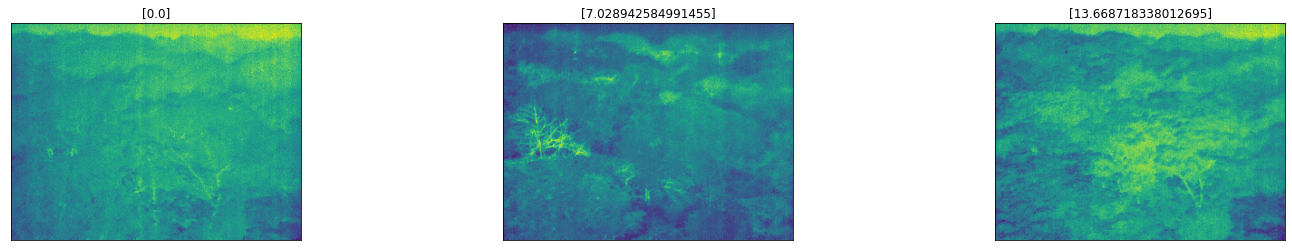

In [9]:
""" VISUALIZE A BATCH OF THE DATA 
    Taken straight from dataloader """
os.chdir(startingDir)
#csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
os.chdir(csvfilesMLLocation)

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
print(images.shape)
images = images.numpy() # convert images to numpy for display
#print(images)

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].item()])
    # Save Images for inspection
    print(images[idx].shape)
os.chdir(startingDir)

In [70]:
"""Working network"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Convulutional Layer 3 (sees 80 x 60 x 32 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Convulutional Layer 4 (sees 40 x 30 x 64 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(128 * 20 * 15, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 20 * 15)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

In [103]:
#n_epochs = 50
#raise Exception("Not currently creating new model")
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr =0.001)
# defining the scheduler, to handle learning rate changes
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.97)

# lmbda = lambda epoch: 1.22 #float(epoch) / 20.0
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
# rater = 0.001
# for epoch in range(1,n_epochs):
#     print("Epoch Number", epoch, "has LR:", rater * lmbda(epoch))
#     rater = rater * lmbda(epoch)
    
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [104]:
torch.cuda.empty_cache() 

In [105]:
# Optimization? Best for inputs that do not change in size (this network)
# "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
torch.backends.cudnn.benchmark = True

# Check that we are on GPU
for p in model.parameters():
    print(p.device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [50]:
""" IMPORT MODEL FOR RETRAIN """
os.chdir(csvfilesMLLocation)
importFlag = input("Are you sure you want to overwrite this model? ")
if importFlag != "Yes":
    raise exception

# Print out values and images that have large differences in target/value
#importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Good_Models/model_BCI_old_method_4000.pt"
importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/model_BCI.pt"
# Track test loss

num_predictions = len(test_indices)

# Import model
valid_loss_min = 12.260173
model.load_state_dict(torch.load(importModelPath))

Are you sure you want to overwrite this model? Yes


<All keys matched successfully>

In [106]:
#optimizer.param_groups[0]['lr'] = 0.001
optimizer.param_groups[0]['lr'] = 0.001

In [107]:
""" TRAINING OF MODEL """



# CHECK VALID AND TRAIN LOSS FOR VALID VAS
# current saved model from runs as seen



os.chdir(startingDir)
#csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
os.chdir(csvfilesMLLocation)
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 80
test_loss = 0.0
valid_loss_min = np.Inf    # Track change in validation loss, set


train_loss_vals = []
valid_loss_vals = []
epochCounter = []
lr_vals = []

for epoch in range(1, n_epochs+1):
    epochCounter.append(epoch)
    lr_vals.append(optimizer.param_groups[0]['lr'])    
    # Measurement of epoch times
    start = time.time()
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    # Update validation loss list
    valid_loss_vals.append(valid_loss)
    # Update training loss list
    train_loss_vals.append(train_loss)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
        
    # save model no matter performance
    torch.save(model.state_dict(), 'model_BCI_unoptim.pt')
    
    # End of time check
    print(f'Time: {time.time()-start}')
    # Time of completion
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    print("LR:",optimizer.param_groups[0]['lr'])
#     scheduler.step()
#     print("After LR:",optimizer.param_groups[0]['lr'])

    # Step the lr_scheudler
#     firstFlag = True
#     secondFlag = True
#     thirdFlag = True
#     if epoch > 16 and firstFlag:
#         firstFlag = False
#         optimizer.param_groups[0]['lr'] = 0.01
#     if epoch > 11 and secondFlag:
#         secondFlag = False
#         optimizer.param_groups[0]['lr'] = 0.005
#     if epoch > 5 and thirdFlag:
#         thirdFlag = False
#         optimizer.param_groups[0]['lr'] = 0.002
        
    if epoch >= 40:
        scheduler.step()
#     if epoch % 4 == 0:
#         if optimizer.param_groups[0]['lr'] == 0.10:
#             optimizer.param_groups[0]['lr'] = 0.01
#         if optimizer.param_groups[0]['lr'] == 0.01:
#             optimizer.param_groups[0]['lr'] = 0.10
        
print("Operation Complete")

# 3batchsize Epochs for 55,000 take 1446 s per epoch
# Epochs for 10,000 files take 280 s per epoch
# Epochs for 4,000 files take 101 s per epoch
# Epochs for 2,500 files take 65 s per epoch
# Epochs for 933 files take 24 s per epoch

Epoch #: 1
Epoch: 1 	Training Loss: 60.282632 	Validation Loss: 46.830225
Validation loss decreased (inf --> 46.830225).  Saving model ...
Time: 275.34548449516296
Current Time = 19:23:26
LR: 0.001
Epoch #: 2
Epoch: 2 	Training Loss: 48.145139 	Validation Loss: 36.611346
Validation loss decreased (46.830225 --> 36.611346).  Saving model ...
Time: 280.9212598800659
Current Time = 19:28:07
LR: 0.001
Epoch #: 3
Epoch: 3 	Training Loss: 42.629069 	Validation Loss: 35.363333
Validation loss decreased (36.611346 --> 35.363333).  Saving model ...
Time: 284.2602756023407
Current Time = 19:32:51
LR: 0.001
Epoch #: 4
Epoch: 4 	Training Loss: 36.410130 	Validation Loss: 27.498722
Validation loss decreased (35.363333 --> 27.498722).  Saving model ...
Time: 279.4165964126587
Current Time = 19:37:30
LR: 0.001
Epoch #: 5
Epoch: 5 	Training Loss: 33.665197 	Validation Loss: 26.148371
Validation loss decreased (27.498722 --> 26.148371).  Saving model ...
Time: 278.99771666526794
Current Time = 19:42:09

Validation loss decreased (12.050691 --> 11.755144).  Saving model ...
Time: 281.54972672462463
Current Time = 23:11:27
LR: 0.0007837433594376959
Epoch #: 49
Epoch: 49 	Training Loss: 11.465133 	Validation Loss: 10.923876
Validation loss decreased (11.755144 --> 10.923876).  Saving model ...
Time: 292.50067162513733
Current Time = 23:16:19
LR: 0.000760231058654565
Epoch #: 50
Epoch: 50 	Training Loss: 11.071877 	Validation Loss: 11.441918
Time: 337.6788001060486
Current Time = 23:21:57
LR: 0.000737424126894928
Epoch #: 51
Epoch: 51 	Training Loss: 10.933875 	Validation Loss: 10.956271
Time: 331.02606415748596
Current Time = 23:27:28
LR: 0.0007153014030880802
Epoch #: 52
Epoch: 52 	Training Loss: 10.755591 	Validation Loss: 11.825155
Time: 328.57725763320923
Current Time = 23:32:56
LR: 0.0006938423609954377
Epoch #: 53
Epoch: 53 	Training Loss: 10.485046 	Validation Loss: 12.743159
Time: 329.8201415538788
Current Time = 23:38:26
LR: 0.0006730270901655745
Epoch #: 54
Epoch: 54 	Training 

KeyboardInterrupt: 

In [78]:
""" EPOCH TIME CALC """
fileSize = 5000.0
minutesToTrain = 60 * 3

secondsPerEpoch = (0.0287*(fileSize) - 6.4268)
secondsToTrain = minutesToTrain * 60.0
epochsToUse = secondsToTrain/secondsPerEpoch
print("To train for", minutesToTrain, "minutes use", epochsToUse, "epochs") 

To train for 180 minutes use 78.79001876369706 epochs


In [39]:
torch.save(model.state_dict(), 'model_BCItrainbigf.pt')

In [95]:
temp_train_loss_vals = train_loss_vals
temp_valid_loss_vals = valid_loss_vals
temp_epochCounter = epochCounter
temp_lr_vals = lr_vals
print(train_loss_vals)
print(valid_loss_vals)
print(epochCounter)
print(lr_vals)

[48.49456891987132, 32.92883348881868, 28.72843727063893, 24.2849374791179, 22.711425794438146, 21.024070187639495, 20.05513064356887, 19.583890223065573, 18.142986320227468, 17.695108623089077, 17.54831202850365, 16.810329620899257, 16.10319041239918, 15.780081836191984, 15.10737209399218, 14.439001860514985, 14.0196505989415, 13.958352770702785, 13.206728516897275, 12.880174546561866, 12.731400948208744, 12.365207303139972, 12.212077501155127, 12.103079655932628, 11.441563352380062, 11.066425246710262, 10.967548815471602, 11.032192830625828, 10.615176637045565, 10.05187028388485, 10.338695699199414, 9.754732614584329, 9.798055516829368, 9.52579261794934, 9.42928987405059, 9.314350070653695, 9.446980352985603, 9.366926611099299, 9.014962821765454, 8.943506879737173, 8.70701099798687, 8.708198945773276, 8.384657049701238, 8.06600011821186, 8.01294697486019, 8.262726789224285, 7.869302674715208, 7.89853806675017, 7.55340496378943, 7.579413583579568, 7.539443263061695, 7.4325187638701244

C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdataFULL\BCIML_Dataset


<Figure size 1080x72 with 0 Axes>

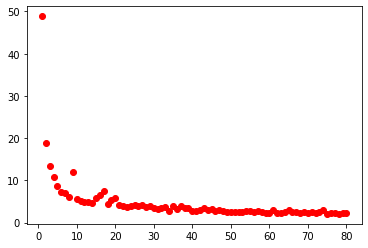

<Figure size 1080x72 with 0 Axes>

In [80]:
""" CREATION OF TEST RANGE LR PLOT """
print(os.getcwd())
plt.scatter(epochCounter, valid_loss_vals, c="red")
#plt.xlim(0,0.05)
# plt.ylim(0,100)
plt.figure(figsize=(15,1))


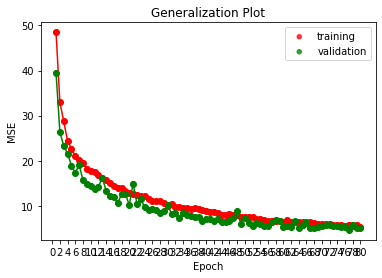

In [96]:
""" CREATION OF GENERALIZATION PLOT """
# genPlotFig =plt.figure()
# genPlotFig.add_axes([0,0,1,1])
# ax.scatter(epochCounter, train_loss_vals, color='r')
# ax.scatter(epochCounter, valid_loss_vals, color='b')

# ax.set_title('Genralization Plot')
colors = ("red", "green")
groups = ("training", "validation")
data = ((epochCounter, train_loss_vals), (epochCounter, valid_loss_vals))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    plt.plot(x,y,'-o',c=color)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
y = np.array([2,4,6,8,10,12,14,16,18])
plt.xticks(np.arange(0, n_epochs+2, step=2))

plt.title("Generalization Plot")
plt.legend()
plt.show()

In [45]:
torch.set_printoptions(precision=4, sci_mode=False)

In [97]:
""" TESTING OF MODEL """

# Print out values and images that have large differences in target/value

# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()
tarList = list()
outList = list()
start = time.time()
counter = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()
        
        for tar, out in zip(target, output):
            tarList.append(tar.item())
            outList.append(out.item())
        
        if counter < 10:
            print("test loss from", counter, ":", loss.item())
            print("Output of network:\t", output)
            print("Target Values:\t\t", target,"\n")
        
        # Example data tensors
        if counter < 2:
            print("loss from this run:", loss.item())
            #print("Output of network:\t", output)
            counterTHIS = 0
            for value in output:
                counterTHIS += 1
                if value.item() > 2.0:
                    print("Output", counterTHIS, ":", value.item())
            counterTHIS = 0
            for value in target:
                counterTHIS += 1
                if value.item() > 2.0:
                    print("Target", counterTHIS, ":", value.item())
            #print("Target Values:\t", target,"\n")
            counter += 1
            # CHECK LOss HEEWRE
        


    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
print(f'Time: {time.time()-start}')

test loss from 0 : 13.141474723815918
Output of network:	 tensor([ 0.3699, 13.0453, 15.5813, 19.8985,  0.4429,  0.4621], device='cuda:0')
Target Values:		 tensor([ 0.0000, 14.5265, 24.2930, 20.3614,  0.0000,  0.0000], device='cuda:0') 

loss from this run: 13.141474723815918
Output 2 : 13.04529857635498
Output 3 : 15.581297874450684
Output 4 : 19.89851188659668
Target 2 : 14.526541709899902
Target 3 : 24.293010711669922
Target 4 : 20.361448287963867
test loss from 1 : 6.873939514160156
Output of network:	 tensor([ 0.2174, 10.3571,  0.2678, 14.2752, 17.7657, 20.5820], device='cuda:0')
Target Values:		 tensor([ 0.0000, 10.5683,  0.0000, 16.4461, 16.3917, 26.4539], device='cuda:0') 

loss from this run: 6.873939514160156
Output 2 : 10.357067108154297
Output 4 : 14.275217056274414
Output 5 : 17.765684127807617
Output 6 : 20.58198356628418
Target 2 : 10.5683012008667
Target 4 : 16.44609260559082
Target 5 : 16.391740798950195
Target 6 : 26.453916549682617
test loss from 2 : 7.974952697753906

Output of network:	 tensor([ 0.2299, 19.5260,  6.4126, 16.1177, 15.0269,  1.2946], device='cuda:0')
Target Values:		 tensor([ 0.0000, 24.4042,  7.4114, 15.8918, 15.0032,  0.0000], device='cuda:0') 

test loss from 2 : 0.6491706371307373
Output of network:	 tensor([ 0.5467,  0.1255, 19.4299, -0.6359, 17.2151, 22.6114], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 18.5444,  0.0000, 17.8083, 24.0397], device='cuda:0') 

test loss from 2 : 0.4529010057449341
Output of network:	 tensor([15.9805,  0.6449,  0.4124, 10.1656,  0.3499, -0.0828], device='cuda:0')
Target Values:		 tensor([17.3841,  0.0000,  0.0000,  9.9870,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 2.4896914958953857
Output of network:	 tensor([21.6631,  8.8705, 12.8079,  3.7947, 15.7906,  0.5201], device='cuda:0')
Target Values:		 tensor([24.3213,  9.4306, 12.9131,  6.3104, 16.7645,  0.0000], device='cuda:0') 

test loss from 2 : 2.218710422515869
Output of network:	 tensor([3.6546, 0.2610, 8.4157, 1

Target Values:		 tensor([0.0000, 0.0000, 0.0000, 0.4687, 0.0000, 0.2076], device='cuda:0') 

test loss from 2 : 2.510043144226074
Output of network:	 tensor([ 7.2927,  0.1303,  0.1222, 23.4711, 12.9436,  0.1998], device='cuda:0')
Target Values:		 tensor([ 8.3437,  0.0000,  0.0000, 26.5446, 15.0502,  0.0000], device='cuda:0') 

test loss from 2 : 6.599604606628418
Output of network:	 tensor([2.3526, 6.8237, 3.1616, 8.3451, 5.5144, 0.2034], device='cuda:0')
Target Values:		 tensor([ 2.3342,  3.8903,  0.7781, 12.0610,  8.8998,  0.0000], device='cuda:0') 

test loss from 2 : 2.5644655227661133
Output of network:	 tensor([ 0.0497,  1.4892, 22.5756, 23.9007,  2.6465, -0.3182], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 25.1227, 23.5873,  5.1920,  0.0000], device='cuda:0') 

test loss from 2 : 0.9044703245162964
Output of network:	 tensor([ 5.3674, 21.6321,  0.0472,  0.4083,  9.0323,  0.1425], device='cuda:0')
Target Values:		 tensor([ 3.5133, 21.2343,  0.0000,  0.0000, 10.31

         3.3466e-01], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 22.5954,  0.0000,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 1.8993180990219116
Output of network:	 tensor([ 0.3638,  0.5959,  0.4111,  1.3565, 12.1392, 12.7487], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000,  2.0107, 11.2318,  9.6684], device='cuda:0') 

test loss from 2 : 0.33790624141693115
Output of network:	 tensor([ 0.1933,  7.4315,  0.1697,  1.0596,  0.8805, -0.1854], device='cuda:0')
Target Values:		 tensor([0.0000, 7.6015, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0') 

test loss from 2 : 20.288047790527344
Output of network:	 tensor([19.9762, 22.9352, 17.8750, 22.7802, 15.7248,  0.3898], device='cuda:0')
Target Values:		 tensor([22.6587, 26.3657, 20.5123, 32.2804, 18.0492,  0.0000], device='cuda:0') 

test loss from 2 : 0.16357573866844177
Output of network:	 tensor([-0.1186,  0.6382,  0.3684,  0.1033,  0.3197,  0.5581], device='cuda:0')
Target Values:		 

Output of network:	 tensor([20.0802, 15.9834,  0.2262, 18.5331,  5.0400,  0.0818], device='cuda:0')
Target Values:		 tensor([21.8775, 15.3040,  0.0000, 17.8472,  6.4508,  0.0000], device='cuda:0') 

test loss from 2 : 5.327770233154297
Output of network:	 tensor([13.3080,  0.8538,  9.5298,  0.2558, 25.5595,  0.0568], device='cuda:0')
Target Values:		 tensor([18.7515,  0.0000, 10.7342,  0.0000, 25.8536,  0.0000], device='cuda:0') 

test loss from 2 : 0.8371719121932983
Output of network:	 tensor([16.7226,  0.5157,  0.1332,  0.5087, 21.4223, 12.9869], device='cuda:0')
Target Values:		 tensor([17.5378,  0.0000,  0.0000,  0.0000, 22.9769, 11.8039], device='cuda:0') 

test loss from 2 : 3.370220184326172
Output of network:	 tensor([19.0259, 18.8489, 21.9696, 18.3194, 11.9181,  0.5699], device='cuda:0')
Target Values:		 tensor([20.5378, 18.3765, 24.5433, 20.8616,  9.8444,  0.0000], device='cuda:0') 

test loss from 2 : 2.432192087173462
Output of network:	 tensor([ 0.2647, 23.6503,  6.7051, 

Target Values:		 tensor([ 0.0000,  0.0000, 20.0587,  6.0877, 14.1994, 18.5441], device='cuda:0') 

test loss from 2 : 12.13580322265625
Output of network:	 tensor([ 4.9628, 15.3881,  6.3849,  3.7118, 17.9161,  0.3878], device='cuda:0')
Target Values:		 tensor([ 5.1925,  8.4947,  3.4791,  0.0000, 16.2217,  0.0000], device='cuda:0') 

test loss from 2 : 1.8550337553024292
Output of network:	 tensor([14.1900,  0.1164,  0.4986,  0.3216, 23.2740,  1.1625], device='cuda:0')
Target Values:		 tensor([17.0461,  0.0000,  0.0000,  0.0000, 24.3947,  0.0000], device='cuda:0') 

test loss from 2 : 8.052712440490723
Output of network:	 tensor([13.2387,  1.9008,  9.6515,  0.1280,  0.7002,  0.3638], device='cuda:0')
Target Values:		 tensor([13.1935,  3.5066, 16.3669,  0.0000,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 7.385156154632568
Output of network:	 tensor([12.2743, -0.1693, 21.1527,  0.5959,  2.3526, 17.8620], device='cuda:0')
Target Values:		 tensor([11.7830,  0.0000, 23.3244,  0.

test loss from 2 : 0.9069656133651733
Output of network:	 tensor([ 0.5834,  0.3808,  0.3392,  0.5928, 10.8896, 20.7487], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000,  0.0000, 13.0075, 20.6803], device='cuda:0') 

test loss from 2 : 14.289403915405273
Output of network:	 tensor([7.2334], device='cuda:0')
Target Values:		 tensor([3.4533], device='cuda:0') 

Test Loss (mean squared error): 0.721824

Time: 53.09096908569336


In [98]:
print("Targets:",tarList)
print("Outputs",outList)

Targets: [0.0, 14.526541709899902, 24.293010711669922, 20.361448287963867, 0.0, 0.0, 0.0, 10.5683012008667, 0.0, 16.44609260559082, 16.391740798950195, 26.453916549682617, 12.036717414855957, 8.871044158935547, 0.0, 0.0, 0.0, 3.7950503826141357, 12.869190216064453, 24.689897537231445, 0.774172842502594, 0.0, 24.129533767700195, 0.0, 8.804533004760742, 10.974781036376953, 0.0, 0.0, 16.477291107177734, 18.15212631225586, 11.312816619873047, 28.27166175842285, 0.0, 15.377140045166016, 0.0, 0.0, 0.3041367530822754, 18.620262145996094, 0.0, 13.61642837524414, 0.0, 11.295207977294922, 0.0, 17.358793258666992, 17.830720901489258, 23.055557250976562, 0.0, 5.442497253417969, 0.0, 2.9322566986083984, 0.0, 0.0, 23.17259407043457, 0.0, 0.0, 0.0, 15.137679100036621, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.551868438720703, 0.0, 0.0, 0.0, 0.0, 0.0, 18.07932472229004, 0.0, 0.0, 14.6112699508667, 21.74184226989746, 0.0, 0.0, 14.706028938293457, 0.0, 8.062973022460938, 0.0, 11.615882873535156, 0.0, 0.0, 20.204

Outputs [0.36987173557281494, 13.04529857635498, 15.581297874450684, 19.89851188659668, 0.4429105520248413, 0.46209728717803955, 0.2174067497253418, 10.357067108154297, 0.26782894134521484, 14.275217056274414, 17.765684127807617, 20.58198356628418, 11.082367897033691, 15.279942512512207, 1.0745017528533936, 0.23600316047668457, 0.8794890642166138, 1.8249731063842773, 6.781110763549805, 25.50713539123535, 1.0645723342895508, -0.2849135398864746, 21.947324752807617, 0.2989182472229004, 12.552326202392578, 13.444944381713867, 0.4996786117553711, 0.06124377250671387, 16.735750198364258, 17.305391311645508, 9.75700569152832, 26.58597183227539, 0.0025284290313720703, 12.848843574523926, 0.21334052085876465, -0.2352900505065918, 0.33936095237731934, 18.380050659179688, 0.6838605403900146, 10.952248573303223, 1.923542857170105, 12.134137153625488, 0.379256010055542, 14.530362129211426, 22.348928451538086, 23.046316146850586, 0.4639817476272583, 5.514366149902344, 0.5708708763122559, 5.92696094

In [62]:
""" TESTING OF IMPORTED MODEL """
os.chdir(csvfilesMLLocation)

# Print out values and images that have large differences in target/value
#importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata9000/model_BCI.pt"
#importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Good_Models/model_BCItrainbigf.pt"
importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/model_BCI.pt"
# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Import model
model2 = BCIModel()
model2.cuda()
model2.load_state_dict(torch.load(importModelPath))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model2.cuda()

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model2.eval()

max_loss = -10.0
targetList = [-10.0,-10.0,-10.0]
outputList = [-10.0,-10.0,-10.0]

thresh_max = 13
max_count = 0
not_included_count = 0

start = time.time()
counter = 0
predictions_divide_three = 0
test_loss_real = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        predictions_divide_three += 1
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        
        if(loss.item() > thresh_max):
            max_count += 1
        
        if(loss.item() > max_loss):
            max_loss = loss.item()
#             for num in range(batch_size):
#                 targetList[num] = target[num].item()
#                 outputList[num] = output[num].item()
        
        
        test_loss_real += loss.item()
        # Update test loss
        if(loss.item() < thresh_max):
            test_loss += loss.item()
        else:
            not_included_count += 1
        
        #print(type(target[0].item()))
        
        #raise Exception("DO NOT TRAIN, EVALUATION ONLY")
        
        # Example data tensors
        if counter < 10:
            print("test loss from", counter, ":", loss.item())
            print("Output of network:\t", output)
            print("Target Values:\t\t", target,"\n")
            counter += 1
        
    test_loss = test_loss/((predictions_divide_three-not_included_count)*3)
    test_loss_real = test_loss_real/(predictions_divide_three*3)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
    print('Test Loss Real (mean squared error): {:.6f}\n'.format(test_loss_real))
print(f'Time: {time.time()-start}')

print("Max loss:", max_loss)
print("targets:", targetList)
print("output:", outputList)
print("max_count:", max_count)



#look at difference between with and without bigerros

CUDA is available!  Training on GPU ...
test loss from 0 : 8.705543518066406
Output of network:	 tensor([12.8590, 15.7529, -0.3846, 12.2453,  9.3890,  4.3938,  2.5041, 24.0620,
        28.4192,  1.5286, 12.6894, 26.6492, 22.8743,  0.9076,  1.4365, -0.0561,
         1.4544,  1.8497, 27.9742,  2.8806,  2.1493, 38.4997, 14.5286,  0.3495,
        25.0275, 28.5833,  0.9340,  1.0857, 12.7810,  0.6429, 21.6899,  0.4041,
        14.1196,  5.7087,  1.1327,  1.4717,  5.4660,  0.6382, 15.6079,  0.6562,
         0.2129, 19.7411, 14.8339, 10.6008,  0.9039,  0.7554, 26.4753,  0.6610,
         0.7440,  2.2295, -0.2550,  1.0393, 12.0048,  1.5124,  0.5966,  5.7378,
        20.1925,  9.6816, 24.3721, 12.1435], device='cuda:0')
Target Values:		 tensor([ 8.8612, 13.8704,  0.0000, 14.0826, 16.7069,  9.9999,  3.4293, 27.1545,
        30.5333,  0.0000, 15.6925, 29.5445, 17.7824,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, 25.2060,  2.0798,  0.0000, 38.5423, 16.9126,  0.0000,
        16.4176, 29.5312

         0.0000, 16.4062, 25.5163, 11.2581], device='cuda:0') 

test loss from 6 : 13.554101943969727
Output of network:	 tensor([22.2246,  6.0470, 21.7611, 27.4144,  2.6340,  2.2164, 18.9301, 25.2858,
         0.7107,  0.4372,  0.9210,  3.9535, 18.2637,  0.3961,  0.6879, 28.7474,
         0.6347, 15.7088,  0.2770, 24.3999, -0.6282,  0.0298,  1.0523, -1.1279,
        16.1600,  0.3795,  1.9632,  0.8288, 19.0213,  2.5543, 26.4818,  1.0209,
        26.9810,  0.2932,  3.7189,  0.3173,  1.2918, 20.3049, -0.2841, 26.5941,
         0.8347,  0.5170,  0.0850,  7.9953,  7.1982, 19.3707, 20.3310,  0.1957,
         2.7315, 13.7008, 22.0937, 16.0796, -0.0333,  1.6782, 16.1911, 27.9657,
        20.2500,  4.4978,  1.5055, -0.1137], device='cuda:0')
Target Values:		 tensor([22.2571, 12.2480, 26.6621, 30.1222,  0.0000,  0.0000, 27.6280, 23.9268,
         0.0000,  0.0000,  0.0000,  4.0756, 16.6665,  0.0000,  0.0000, 25.7475,
         0.0000, 21.4920,  0.0000, 26.1588,  0.0000,  0.0000,  0.0000,  0.0000,

In [63]:
print(num_predictions)

6440
